# Hamoye : Introduction to Python for Machine Learning

This notebook investigates a public utility dataset and explored techniques on data cleaning, wrangling, and provides summary statistics and visualisations.

This is a submission of the Hamoye Introduction to Python for Machine Learning course.

## 1. Data Cleaning

This sections explores the challenges the given dataset posed, and also techniques on how to overcome them. 

The first challenge involves the missing values (i.e `Nan`) found in the `fuel_unit` field of the dataset. The total number of missing values sum up to 180.

The second challenge lies in the `plant_name_ferc1` field, where spelling mistakes could be found, as well as various forms of the same name (i.e `cheyenne prairie` and `cheyenne prairie 42%`, etc). Aggregating these various forms as well as handling spelling errors would be a vital part of the data cleaning procedure.

In [1]:
# Add all import statements here!
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
import missingno as msno

### 1.1 MNAR or not?

Before filling in the empty values in the `fuel_unit`, we should first determine if the data is Missing Not At Random (MNAR) or not.

We also verify that `fuel_unit` is the only column with `Nan` (or `null`) values:

In [2]:
# Read the dataset from the url given
url = 'https://raw.githubusercontent.com/WalePhenomenon/climate_change/master/fuel_ferc1.csv'
df = pd.read_csv(url)

df.head()

,record_id,utility_id_ferc1,report_year,plant_name_ferc1,fuel_type_code_pudl,fuel_unit,fuel_qty_burned,fuel_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu
0,f1_fuel_1994_12_1_0_7,1,1994,rockport,coal,ton,5377489.0,16.590,18.59,18.53,1.121
1,f1_fuel_1994_12_1_0_10,1,1994,rockport total plant,coal,ton,10486945.0,16.592,18.58,18.53,1.120
2,f1_fuel_1994_12_2_0_1,2,1994,gorgas,coal,ton,2978683.0,24.130,39.72,38.12,1.650
3,f1_fuel_1994_12_2_0_7,2,1994,barry,coal,ton,3739484.0,23.950,47.21,45.99,1.970
4,f1_fuel_1994_12_2_0_10,2,1994,chickasaw,gas,mcf,40533.0,1.000,2.77,2.77,2.570


In [3]:
# Check for any row values with null
df.isnull().sum()

record_id                         0
utility_id_ferc1                  0
report_year                       0
plant_name_ferc1                  0
fuel_type_code_pudl               0
fuel_unit                       180
fuel_qty_burned                   0
fuel_mmbtu_per_unit               0
fuel_cost_per_unit_burned         0
fuel_cost_per_unit_delivered      0
fuel_cost_per_mmbtu               0
dtype: int64

The result above shows the `fuel_unit` field with 180 missing values. The fact that only the `fuel_unit` contains null values shows a potential of the values to be Missing Completely At Random. Also the percentage of the missing data (~0.7%), is also a strong indicator of the randomness of the missing data, as no pattern or correlation amongst the other columns could be determined.

Since the `fuel_unit` is the only column with `null` values, then it cannot be determined if the data is Missing At Random. It can't also be determined if the values were left out on purpose (i.e Missing Not At Random). 
Hence, the missing data is said to be Missing Completely At Random.

### 1.2 Handling Missing Data

A naive way to handle missing values would be to not handle them at all: remove all the rows where the `fuel_unit` value is `Nan`. This however, could lead to false conclusions being drawn from the data analysed, since the information is said to be incomplete. Also, there are other columns being affected if an entire row is removed, and though the missing data (~0.7%) is said to be small, it is not insignificant.

Another method would be to replace all the missing values with the `most_frequent` value given in the `fuel_unit` column.

Domain knowledge of both the missing data and the observed data can allow for more sophisticated measures in filling in the values with missing data.

For imputting null values, I train a `RandomForestClassifier` model on a sample of the dataset, with the `fuel_type_code_pudl` as the input feature, and the (non null) `fuel_unit` values as it's label.
I then predict the null `fuel_unit` values using this model.

To do this, we encode categorical values into integers (i.e `{coal, oil, nuclear}` becomes `{0, 1, 2}`):

In [4]:
def ordinalencode(encoder, data, decode=False):
    """
    Encodes or decodes categorical data.
    
    Args:
     encoder: OrdinalEncoder object
     data: categorical data to be transformed into numerical data (or vice versa)
     decode: boolean value to decode or encode. 
    """
    nonulls = np.array(data.dropna())
    impute_reshape = nonulls.reshape(-1,1)
    if decode:
        impute_ordinal = encoder.inverse_transform(impute_reshape)
    else:
        encoder.fit(impute_reshape)
        impute_ordinal = encoder.transform(impute_reshape)
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)

Now let's create our training data and fit a model!

In [5]:
# Create encoder objects for both fuel_unit and fuel_type_code_pudl

fuel_unit_encoder = OrdinalEncoder()
fuel_type_encoder = OrdinalEncoder()

# Encode the data!

ordinalencode(fuel_unit_encoder, df['fuel_unit'])
ordinalencode(fuel_type_encoder, df['fuel_type_code_pudl'])

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Extract the null indices (all 180 values of them), which are the `null` values to be predicted. Taking all the null indices of the `fuel_type_code_pudl` column would give the input values to the trained `RandomForestClassifier` model.

In [6]:
null_indices = df[df['fuel_unit'].isnull()].index

X_predict = np.array(df.loc[null_indices]['fuel_type_code_pudl']).reshape(-1, 1)

assert len(null_indices) == df['fuel_unit'].isnull().sum()

In [7]:
# TODO: randomise the training data,
# TODO: Use 60% of train data to train model and 40% to test model accuracy

train_data = df.dropna() # training data excludes all null values

X = np.array(train_data['fuel_type_code_pudl']).reshape(-1, 1)
y = np.array(train_data['fuel_unit'])
y = y.astype('int')

rf = RandomForestClassifier(random_state=0)
rf.fit(X, y)

RandomForestClassifier(random_state=0)

Predict the output values with trained model.

In [8]:
predicted = rf.predict(X_predict)

# Replace the null values of the `fuel_unit` column in the dataframe.
df.loc[null_indices, 'fuel_unit'] = np.array(predicted)

assert df['fuel_unit'].isnull().sum() == 0

In [9]:
# Decode! (i.e from {0, 1, 2} to {coal, oil, gas})
ordinalencode(fuel_unit_encoder, df['fuel_unit'], decode=True)
ordinalencode(fuel_type_encoder, df['fuel_type_code_pudl'], decode=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### 1.3 TODO: Cleaning the `fuel_cost_per_unit_burned` column

#### 1.3.1 Removing negative values

Some values in the `fuel_cost_per_unit_burned`, `fuel_cost_per_unit_delivered` and `fuel_cost_per_mmbtu` were found to be less than zero. 

A negative cost value in any of the `integer` or `float` data type columns in any case, would be discrepancy, assumming there is no such thing as negative cost in the actual sense. To fix this, we make sure to eliminate negative values by taking the absolute value of all the `integer` or `float` data type columns.

In [10]:

df['fuel_qty_burned'] = df['fuel_qty_burned'].abs()
df['fuel_cost_per_unit_burned'] = df['fuel_cost_per_unit_burned'].abs()
df['fuel_mmbtu_per_unit'] = df['fuel_mmbtu_per_unit'].abs()
df['fuel_cost_per_unit_burned'] = df['fuel_cost_per_unit_burned'].abs()
df['fuel_cost_per_unit_delivered'] = df['fuel_cost_per_unit_delivered'].abs()
df['fuel_cost_per_mmbtu'] = df['fuel_cost_per_mmbtu'].abs()

assert df[df['fuel_qty_burned'] < 0]['fuel_qty_burned'].sum() == 0
assert df[df['fuel_cost_per_unit_burned'] < 0]['fuel_cost_per_unit_burned'].sum() == 0
assert df[df['fuel_mmbtu_per_unit'] < 0]['fuel_mmbtu_per_unit'].sum() == 0
assert df[df['fuel_cost_per_unit_burned'] < 0]['fuel_cost_per_unit_burned'].sum() == 0
assert df[df['fuel_cost_per_unit_delivered'] < 0]['fuel_cost_per_unit_delivered'].sum() == 0
assert df[df['fuel_cost_per_mmbtu'] < 0]['fuel_cost_per_mmbtu'].sum() == 0



### 1.4 TODO: Cleaning the `plant_name_ferc1` column

The second part of the data cleaning process involves `plant_name_ferc1` column, which holds the names of the individual power plant from which the data for a given row was recorded.

**Note: limited analysis was performed using the `other` fuel type as I could not draw any meaningful conclusions while being completely ignorant about the nature of the fuel type (i.e renewable or non-renewable, etc).**

## 2. Exploratory Data Analysis (EDA)

This section explores the data, drawing up various summary statistics, making visualisations and drawing informed conclusions about the data.

### 2.1 How fuel costs impact the viability of the different generation sources

Taking the viability of a fuel source to be the quantity of fuel burnt for that given source, I determine how fuel costs impact the viablility of different generation sources by drawing a scatter plot of the `fuel_qty_burned` against the `fuel_cost_per_unit_burned` as shown below:

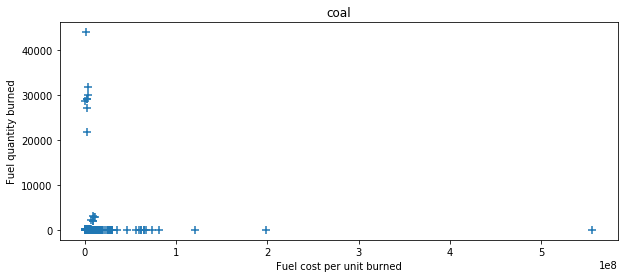

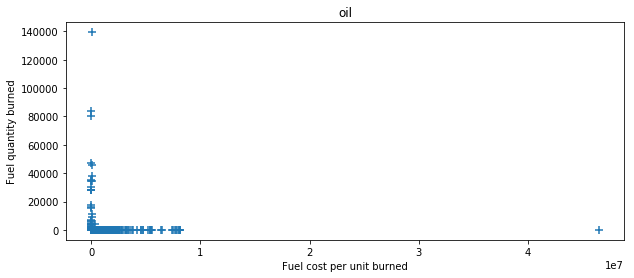

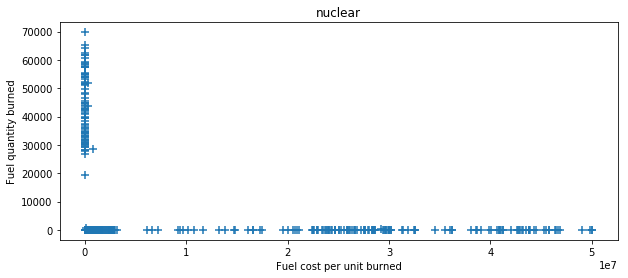

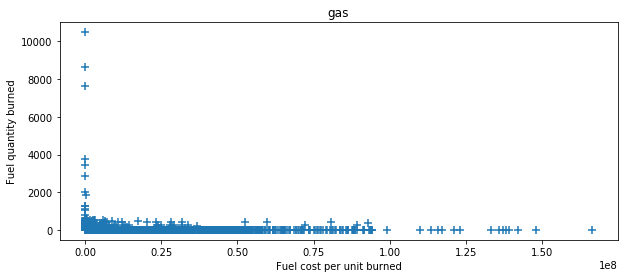

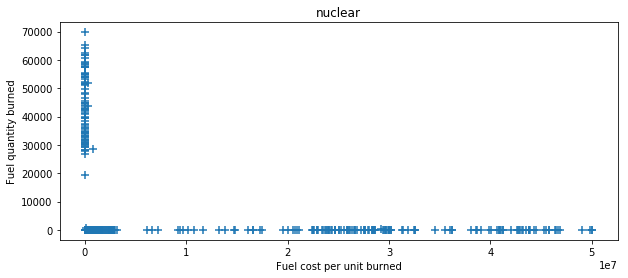

In [ ]:
def plot_scatter(df, fuel_type):
    """
    Helper function to plot scatter graph.
    """

    x = df[df['fuel_type_code_pudl'] == fuel_type]['fuel_qty_burned']
    y = df[df['fuel_type_code_pudl'] == fuel_type]['fuel_cost_per_unit_burned']

    plt.figure(figsize=(10, 4))

    plt.scatter(x, y, s=50, marker="+")
    plt.xlabel('Fuel cost per unit burned')
    plt.ylabel('Fuel quantity burned')
    plt.title(fuel_type)
    plt.show()


plot_scatter(df, 'coal')
plot_scatter(df, 'oil')
plot_scatter(df, 'nuclear')
plot_scatter(df, 'gas')
plot_scatter(df, 'nuclear')
plot_scatter(df, 'waste')
plot_scatter(df, 'other')

The scatter plots drawn above shows that more fuel quantity is burned at a lower fuel cost, hence the fuel type is more viable the lower the fuel cost per unit burned, and vice versa (i.e less fuel is burnt at higher fuel cost per unit burnt values).

### 2.2 Competitiveness of renewable electricity

To determine the competitiveness of renewable electricity, the total fuel cost unit of each record must be known according to the equation below:

`total_fuel_cost = fuel_qty_burned * fuel_cost_per_unit_burned`, where `fuel_qty_burned` and `fuel_cost_per_unit_burned` are the values in their respective columns for a single row.

The `total_fuel_cost` column is then added to the pandas dataframe as shown in the cell below:

In [ ]:
df['total_fuel_cost'] = np.around(df['fuel_qty_burned'] * df['fuel_cost_per_unit_burned'])

The next step would be to plot a bar chart showing the `total_fuel_cost` against the different generation sources such as coal, oil, etc.

I create some helper functions below to make plotting graphs a little bit easier:

In [ ]:
def stat_column_per_year(df, year, fuel_type, column='total_fuel_cost', stat='mean'):
    """
    Return the average value of a given column of a given fuel type, for a given year.
    
    Args:
        df [Pandas Dataframe]: the pandas Dataframe containing the report_year and fuel_type_code_pudl columns
        year [int]: the given year
        fuel_type [string]: i.e coal, oil, nuclear, etc.
        column [string]: column in pandas dataframe `df`
        stat [string]: operation to perform (i.e sum or mean)
        
    Return [float]:
        average value of given column.
    """
    
    assert stat == 'mean' or stat == 'sum'
    
    if stat == 'mean':
        return df[(df['report_year'] == year) & (df['fuel_type_code_pudl'] == fuel_type)][column].mean()
    elif stat == 'sum':
        return df[(df['report_year'] == year) & (df['fuel_type_code_pudl'] == fuel_type)][column].sum()

In [ ]:
def plot_bar(df, column, x_axis_title, y_axis_title, graph_title, log=False):

    years = list(df['report_year'].unique())
    x = np.arange(len(years))
    fig, ax=plt.subplots(figsize= (25,6))
    width = 0.16
    font_size = 20
    stat = 'sum'
    
    coal = [stat_column_per_year(df, year, 'coal', column=column, stat=stat) for year in years]
    gas = [stat_column_per_year(df, year, 'gas', column=column, stat=stat) for year in years]
    oil = [stat_column_per_year(df, year, 'oil', column=column, stat=stat) for year in years]
    nuclear = [stat_column_per_year(df, year, 'nuclear', column=column, stat=stat) for year in years]
    waste = [stat_column_per_year(df, year, 'waste', column=column, stat=stat) for year in years]
    
    ax.bar(x + 0.00, coal, width = width, label='coal')
    ax.bar(x + width, gas, width = width, label='gas')
    ax.bar(x + (2 * width), oil, width = width, label='oil')
    ax.bar(x + (3 * width), nuclear, width = width, label='nuclear')
    ax.bar(x + (4 * width), waste, width = width, label='waste')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_axis_title, fontsize=font_size)
    ax.set_xlabel(x_axis_title, fontsize=font_size)
    ax.set_title(graph_title, fontsize=font_size)
    ax.set_xticks(x)
    ax.set_xticklabels(years)
    if log: ax.set_yscale('log')
    ax.legend()

In [ ]:
def plot_trend(df, column, x_axis_title, y_axis_title, graph_title, stat='mean', log=False):
    """
    Helper function to plot graphs.
    """
    
    plt.figure(figsize=(15, 5))

    years = list(df['report_year'].unique())

    y1 = [stat_column_per_year(df, year, 'coal', column=column, stat=stat) for year in years]
    plt.plot(years, y1, label="coal")

    y2 = [stat_column_per_year(df, year, 'gas', column=column, stat=stat) for year in years]
    plt.plot(years, y2, label="gas")

    y3 = [stat_column_per_year(df, year, 'nuclear', column=column, stat=stat) for year in years]
    plt.plot(years, y3, label="nuclear")

    y4 = [stat_column_per_year(df, year, 'oil', column=column, stat=stat) for year in years]
    plt.plot(years, y4, label="oil")

    y5 = [stat_column_per_year(df, year, 'waste', column=column, stat=stat) for year in years]
    plt.plot(years, y5, label="waste")
    
    if log: plt.yscale('log')
    
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.title(graph_title)
    plt.legend()
    plt.show()

In [ ]:
def plot_pie():
    labels = ['Coal', 'Oil', 'Nuclear', 'Gas', 'Waste']
    total_fuel_qty_burned = df['fuel_qty_burned'].sum()

    sizes = [
        (df[df['fuel_type_code_pudl'] == 'coal']['fuel_qty_burned'].sum() / total_fuel_qty_burned) * 100,
        (df[df['fuel_type_code_pudl'] == 'oil']['fuel_qty_burned'].sum() / total_fuel_qty_burned) * 100,
        (df[df['fuel_type_code_pudl'] == 'nuclear']['fuel_qty_burned'].sum() / total_fuel_qty_burned) * 100,
        (df[df['fuel_type_code_pudl'] == 'gas']['fuel_qty_burned'].sum() / total_fuel_qty_burned) * 100,
        (df[df['fuel_type_code_pudl'] == 'waste']['fuel_qty_burned'].sum() / total_fuel_qty_burned) * 100,
    ]
    
    explode = (0, 0, 0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', startangle=140)
    ax1.axis('equal')
    ax1.set_title('Fig 3: Pie chart of fuel quantity burnt per fuel type')
    plt.show()

In [ ]:
plot_bar(df, 'fuel_qty_burned', 'Year', 'Total fuel burnt', 'Fig 1: Total fuel burnt per year', log=True)
plot_trend(df, 'fuel_qty_burned', 'Year', 'Total fuel quantity burned', 'Fig 2: Total fuel burnt per year', stat='sum', log=True)
plot_pie()

From the figure `Fig 1` above, `gas` has been the leading energy source being burnt, followed by `coal`, then `nuclear`, and finally `waste`. In order:
1. Gas
2. Coal
3. Nuclear
4. Oil (except in 1995, 1998, and 1999)
5. Waste

The order of this trend was consistent for most of the years observed, as shown in figure `Fig 2`.
Figure `Fig 2` also shows the steady decline of `oil` from 2005, and the incremental rise of `waste` such that by 2017, the total fuel quantity burned for the two fuel types are nearly equal.

The price of `oil` has also historically been affected by political situations in oil producing countries, amongst other political factors outside typical supply-demand ecomics, as this paper by Robert Mabro [1] will indicate, the oil price crisis of 1998 is also reflected in both figures `Fig 1` and `Fig 2`.

In conclusion, `coal`, `gas` and `nuclear` still dominate the energy sources, taking up 99.3 of the combined fuel quantity burned, with `gas` alone at 72.3% as seen in figure `Fig 3`.
The only renewable source, `waste`, is put at 0.1% of fuel quantity burnt, although, according to figure `Fig 2`, it showed a steady increase in fuel quantity burnt throughout the years, indicating some promise for the future.

[1] https://www.oxfordenergy.org/wpcms/wp-content/uploads/2010/11/SP10-TheOilPriceCrisisof1998-RMabro-1998.pdf

### 2.3 Generation mix of utilities over time